# Sample from a univariate Gaussian distribution using a GAN
In this notebook, we'll train a GAN to sample from a 1-dimensional Gaussian distribution. Of course there is no real point in the exercise but show you quickly how th library works.

First, some imports:

In [14]:
import os
import torch
import torch.nn.parallel

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

os.chdir("/home/thomas/Backup/Algorithmen/vegans")
from vegans.GAN import VanillaGAN
from vegans.utils.utils import plot_losses

Now we'll define some variables. `z_dim` is the size of the noise vector (input of the generator), while `mu` and `sigma` are the two parameters of the Gaussian distribution we'll try to learn.

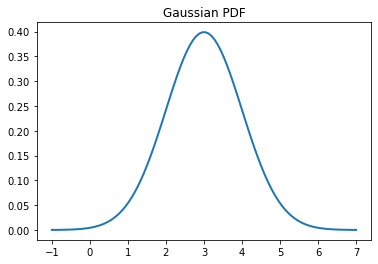

In [15]:
z_dim = 16

mu = 3.
sigma = 1.

def plot_gaussian(mu, sigma):
    x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
    y = (1 / (np.sqrt(2 * np.pi * np.power(sigma, 2)))) * \
        (np.power(np.e, -(np.power((x - mu), 2) / (2 * np.power(sigma, 2)))))
    plt.plot(x, y, lw=2)
    plt.title('Gaussian PDF');
    
plot_gaussian(mu, sigma)

Let's create the training data and check if the empirical distribution of our samples matches our desired PDF:

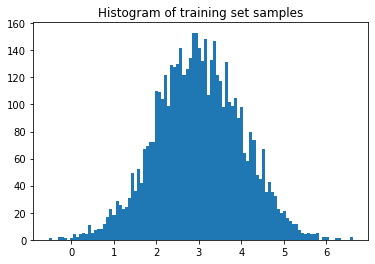

In [16]:
X_train = np.random.normal(loc=mu, scale=sigma, size=5000).reshape(-1, 1)
plt.hist(X_train, bins=100)
plt.title('Histogram of training set samples');

OK looks good!

## Definition of a Generator and a Discriminator:
Here we'll define simple networks with 2 fully connected layers and a ReLU nonlinearity:

In [17]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.hidden_part = nn.Sequential(
            nn.Linear(z_dim, 32),
            nn.LeakyReLU(0.1),
        )
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = self.hidden_part(x)
        x = self.output(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.hidden_part = nn.Sequential(
            nn.Linear(1, 10),
            nn.LeakyReLU(0.1),
            nn.Linear(10, 1)
        )
        self.output = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden_part(x)
        x = self.output(x)
        return x
    
discriminator = Discriminator()
generator = Generator()

Let's see the samples that our (untrained) generator outputs:

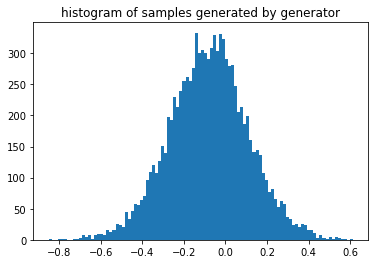

In [18]:
def plot_generator_distribution(generator, n=10000):
    """ Try the generator on a noise mini-batch
    """
    z = torch.from_numpy(np.random.randn(n, z_dim).astype(np.float32))
    samples = generator(z).cpu().detach().numpy().flatten()
    plt.hist(samples, bins=100)
    plt.title('histogram of samples generated by generator');
    
plot_generator_distribution(generator)

They are pretty far from our desired Gaussian; so let's train a GAN to try getting closer.
## Training a GAN
Here we'll use the [classic minimax GAN](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf), training for 30 epochs, and saving 1024 samples along training. We set `folder=None` so that no folder is created where all results would be stored. Otherwise we could give a path like `folder="TrainedModels/GAN"`. All results (summary, images, loss functions, tensorboard information, models) would be saved in that folder. You can control what should be saved in the `fit` method. This folder will never overwrite an existing folder. If the path already exists a new path of the form `folder=path_{TimeStamp}` is created.

In [19]:
gan = VanillaGAN(
    generator, discriminator, z_dim=z_dim, x_dim=1, fixed_noise_size=1024, 
    folder=None, device="cpu"
)

Let's print a summary of the VanillaGAN to get a better overview of what's going on and check that everything is set up correctly.

In [20]:
gan.summary()

Generator
---------
Input shape:  (16,)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             544
         LeakyReLU-2                   [-1, 32]               0
            Linear-3                    [-1, 1]              33
         Generator-4                    [-1, 1]               0
Total params: 577
Trainable params: 577
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------



Adversariat
-----------
Input shape:  (1,)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]              20
         LeakyReLU-2       

We now train the model on the training data. We will print the summary statistics every second epoch and save the losses 10 times per epoch for later plotting purposes. We also diable tensorboard, as it would be an overkill in this situation. If you enable tensorboard the losses are tracked and visualized in a separate tensorboard folder.

In [21]:
gan.fit(X_train, print_every="2e", save_losses_every="0.1e", epochs=10, enable_tensorboard=False)

------------------------------------------------------------
EPOCH: 1
------------------------------------------------------------
------------------------------------------------------------
EPOCH: 2
------------------------------------------------------------
Step: 314 / 1570 (Epoch: 2 / 10, Batch: 157 / 157)
------------------------------------------------------------
Generator: 0.8453125953674316
Adversariat: 0.6832890510559082
Adversariat_fake: 0.562002420425415
Adversariat_real: 0.8045757412910461
RealFakeRatio: 1.4316232204437256


Time left: ~0.039 minutes (Steps remaining: 1256).


------------------------------------------------------------
EPOCH: 3
------------------------------------------------------------
------------------------------------------------------------
EPOCH: 4
------------------------------------------------------------
Step: 628 / 1570 (Epoch: 4 / 10, Batch: 157 / 157)
------------------------------------------------------------
Generator: 0.716100871562957

## Inspecting Results
Let's have a look again at the distribution of samples coming from the generator:

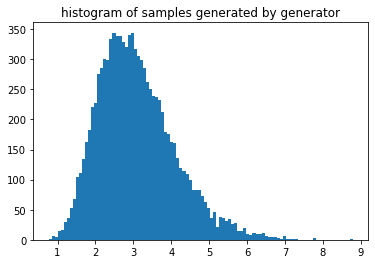

In [22]:
plot_generator_distribution(generator)

Not bad! It looks fairly close to our original Gaussian (note: it's probably possible to do better...).

We can also have a look at the evolution of the discriminator and generator losses:

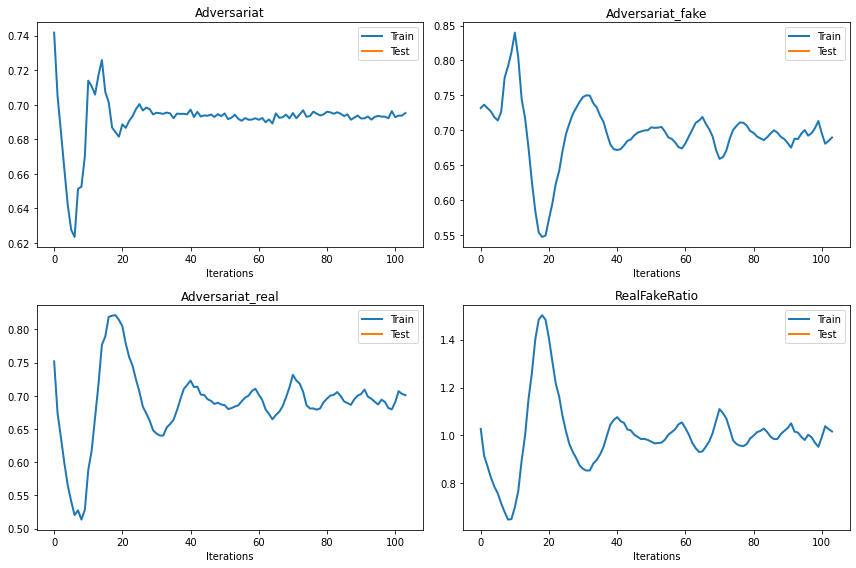

In [23]:
samples_l, losses = gan.get_training_results(by_epoch=False)
fig, axs = plot_losses(losses)

We can see an oscillating pattern which is the norm for GAN training as two neural networks work against each other on the same loss.

To sample more examples we can call:

In [24]:
gan.generate(n=10)

array([[3.419125 ],
       [2.448014 ],
       [2.8406904],
       [4.0358233],
       [3.4519904],
       [3.6490488],
       [2.9952488],
       [2.9098253],
       [1.7239344],
       [3.042408 ]], dtype=float32)